In [1]:


from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from surprise import Reader, Dataset, SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, \
    KNNWithZScore, BaselineOnly, CoClustering, accuracy
from surprise.model_selection import cross_validate, train_test_split
init_notebook_mode(connected=True)
import numpy as np
import pandas as pd
import csv

import sklearn
from sklearn.decomposition import TruncatedSVD

columns = ['id','id2','task','TaskId','rating']
frame = pd.read_csv('DataRecommenderSystem/DataVisitVisitor.csv',sep=',', names=columns)
frame.head()

,id,id2,task,TaskId,rating
0,1,3,1000,1,6
1,2,3,1110,2,6
2,3,3,1100,3,7
3,4,3,1010,4,8
4,5,3,1000000,5,7


In [2]:
columns2 =['TaskId','TaskName','Task']
tasks = pd.read_csv('DataRecommenderSystem/TaskVisitVisitor.csv', sep=',', names = columns2, encoding='latin-1')
task_names = tasks[['TaskId','TaskName','Task']]
task_names.head()

,TaskId,TaskName,Task
0,1,Task1,1000
1,2,Task2,1110
2,3,Task3,1100
3,4,Task4,1010
4,5,Task5,1000000


In [3]:
combined_task_data = pd.merge(frame, task_names, on='TaskId')
combined_task_data.head()

,id,id2,task,TaskId,rating,TaskName,Task
0,1,3,1000,1,6,Task1,1000
1,16,3,1000,1,8,Task1,1000
2,18,3,1000,1,4,Task1,1000
3,26,3,1000,1,5,Task1,1000
4,33,3,1000,1,0,Task1,1000


In [4]:
combined_task_data.groupby('TaskId')['rating'].count().sort_values(ascending=True).head()

filter_interview = combined_task_data['TaskId']==0
combined_task_data[filter_interview]['TaskName'].unique()

array([], dtype=object)

In [5]:
rating_crosstab = combined_task_data.pivot_table(values='rating', index='id', columns=['TaskName','Task'], fill_value=0.01)
rating_crosstab

TaskName,Task1,Task10,Task11,Task2,Task3,Task4,Task5,Task6,Task7,Task8,Task9
Task,1000,1000010,1000110,1110,1100,1010,1000000,1101010,101010,100010,100110
id,,,,,,,,,,,
1,6.00,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
2,0.01,0.01,0.01,6.00,0.01,0.01,0.01,0.01,0.01,0.01,0.01
3,0.01,0.01,0.01,0.01,7.00,0.01,0.01,0.01,0.01,0.01,0.01
4,0.01,0.01,0.01,0.01,0.01,8.00,0.01,0.01,0.01,0.01,0.01
5,0.01,0.01,0.01,0.01,0.01,0.01,7.00,0.01,0.01,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...
96,0.01,0.01,0.01,0.01,4.00,0.01,0.01,0.01,0.01,0.01,0.01
97,0.01,0.01,0.01,5.00,0.01,0.01,0.01,0.01,0.01,0.01,0.01


In [6]:
rating_crosstab.shape
X = rating_crosstab.T
X.shape

(11, 100)

In [7]:
truncated_SDV = TruncatedSVD(n_components=11, random_state=0)

resultant_matrix = truncated_SDV.fit_transform(X)

resultant_matrix.shape

(11, 11)

In [8]:
corr_mat = np.corrcoef(resultant_matrix)
corr_mat.shape
task_names = rating_crosstab.columns
task_list = list(task_names)
task_list
task = task_list.index(('Task1',1000))
task
corr_1 = corr_mat[task]
corr_1.shape
corr_1

with open('DataRecommenderSystem/recommenderSystemVisit.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(corr_1)
    writer.writerow(list(task_names[(corr_1<=1) & (corr_1 > -0.09)]))



In [9]:
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
#add
data = frame['rating'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / frame.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} task-ratings'.format(frame.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)
#add

In [10]:
#add
# Create trace
trace = go.Histogram(x = combined_task_data.TaskId,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 200,
                                  size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Task',
                   xaxis = dict(title = 'Number of Ratings Per Book'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.1)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)
#add

#add
# Create trace
trace = go.Histogram(x = combined_task_data.id,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 200,
                                  size = 10))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.1)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)
#add

In [11]:
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(combined_task_data[['id', 'TaskId', 'rating']], reader)

In [12]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    print(algorithm)
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
smt = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   
print(smt)
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


{'test_rmse': array([2.11323924, 2.48862704, 1.80221833]),
 'fit_time': (0.0010039806365966797, 0.0019996166229248047, 0.0),
 'test_time': (0.0009953975677490234, 0.0, 0.0009961128234863281)}

In [13]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)



Estimating biases using als...
RMSE: 2.2345


2.2345350649393643

In [14]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: # user was not part of the trainset
        return 0
    
def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]
print(best_predictions)
print(worst_predictions)

    uid  iid  rui       est                    details  Iu  Ui       err
6    95    7  7.0  7.168977  {'was_impossible': False}   0   3  0.168977
20   20   10  7.0  7.257227  {'was_impossible': False}   0   4  0.257227
0    98    6  7.0  6.686618  {'was_impossible': False}   0   6  0.313382
8    90    4  7.0  7.404141  {'was_impossible': False}   0   8  0.404141
12   67    1  7.0  6.483519  {'was_impossible': False}   0  17  0.516481
14   64    6  6.0  6.686618  {'was_impossible': False}   0   6  0.686618
18   58    6  6.0  6.686618  {'was_impossible': False}   0   6  0.686618
23   49    3  6.0  6.703063  {'was_impossible': False}   0  10  0.703063
10   89    5  7.0  6.286128  {'was_impossible': False}   0   8  0.713872
11   38    2  6.0  7.299757  {'was_impossible': False}   0   6  1.299757
    uid  iid  rui       est                    details  Iu  Ui       err
24   39   10  5.0  7.257227  {'was_impossible': False}   0   4  2.257227
1    17    2  5.0  7.299757  {'was_impossible': Fal

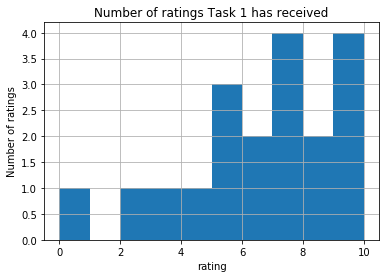

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
combined_task_data.loc[combined_task_data['TaskId'] == 1]['rating'].hist()
#fig = plt.figure()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings Task 1 has received')
plt.show();

